# Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

<div class="alert alert-info"><h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/stationarity.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Stationarity and differencing</font></div>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('D:/ML-Datasets/Udemy-TimeSeries/samples.csv', index_col=0, parse_dates=True)
df.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


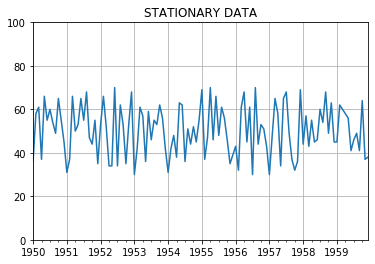

In [3]:
# Lets plot the first column a
df['a'].plot(ylim=[0, 100], title='STATIONARY DATA', grid=True).autoscale(axis='x', tight=True)

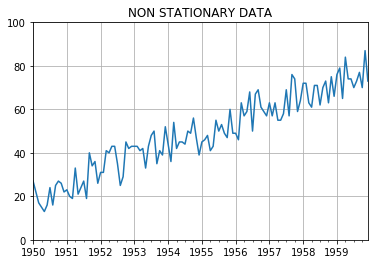

In [4]:
# Where as b is non stationary data
df['b'].plot(ylim=[0, 100], title='NON STATIONARY DATA', grid=True).autoscale(axis='x', tight=True)

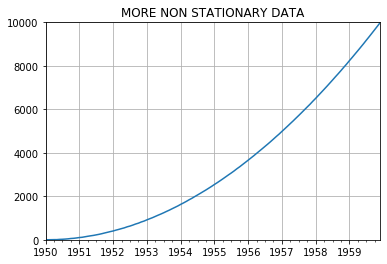

In [5]:
# c is also a non-stationary data
df['c'].plot(ylim=[0, 10000], title='MORE NON STATIONARY DATA', grid=True).autoscale(axis='x', tight=True)

In an upcoming section we'll learn how to test for stationarity.

# Differencing
## First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.


In [6]:
# calculate the first difference of non-stationary dataset 'b'
df['1b'] = df['b'] - df['b'].shift(1)

df[['b', '1b']].head()

,b,1b
1950-01-01,27,NaN
1950-02-01,22,-5.0
1950-03-01,17,-5.0
1950-04-01,15,-2.0
1950-05-01,13,-2.0


Notice that differencing eliminates one or more rows of data from the beginning of the series.

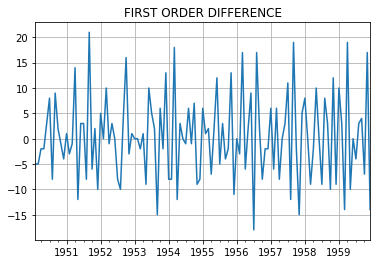

In [7]:
# If we plot the differenced column
df['1b'].plot(title='FIRST ORDER DIFFERENCE', grid=True).autoscale(axis='x', tight=True)

An easier way to perform differencing on a pandas Series or DataFrame is to use the built-in <tt>.diff()</tt> method:

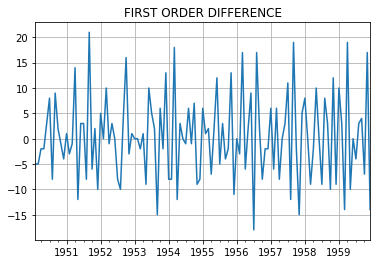

In [8]:
df['1b'] = df['b'].diff()

df['1b'].plot(title='FIRST ORDER DIFFERENCE', grid=True).autoscale(axis='x', tight=True)

### Forecasting on first order differenced data
When forecasting with first order differences, the predicted values have to be added back in to the original values in order to obtain an appropriate forecast.

Let's say that the next five forecasted values after applying some model to <tt>df['d1b']</tt> are <tt>[7,-2,5,-1,12]</tt>. We need to perform an <em>inverse transformation</em> to obtain values in the scale of the original time series.

In [10]:
# For our example we need to build a forecast series from scratch
# First determine the most recent date in the training set, to know where the forecast set should start
df[['b']].tail(3)

,b
1959-10-01,70
1959-11-01,87
1959-12-01,73


In [11]:
# we will set a DateTime index for the forecast set that extends 5 periods into future
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7, -2, 5, -1, 12], index=idx, columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


The idea behind an inverse transformation is to start with the most recent value from the training set, and to add a cumulative sum of Fcast values to build the new forecast set. For this we'll use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [13]:
z['Forecast'] = df['b'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,Forecast
1960-01-01,7,80
1960-02-01,-2,78
1960-03-01,5,83
1960-04-01,-1,82
1960-05-01,12,94


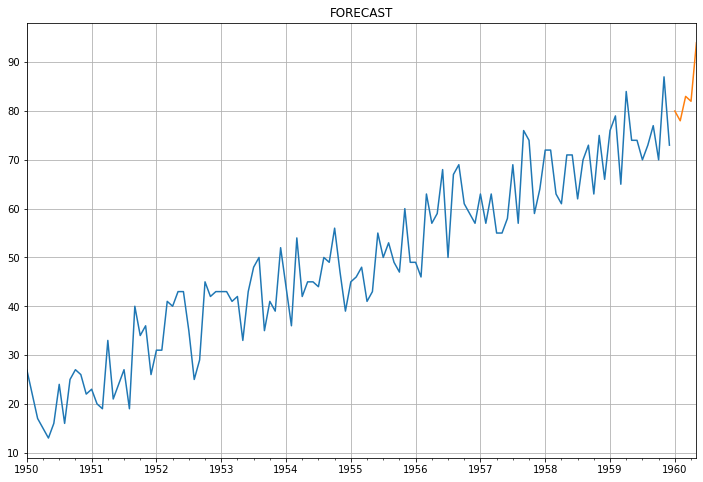

In [14]:
df['b'].plot(figsize=(12, 8), title='FORECAST').autoscale(axis='x', tight=True)
z['Forecast'].plot(grid=True)

## Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

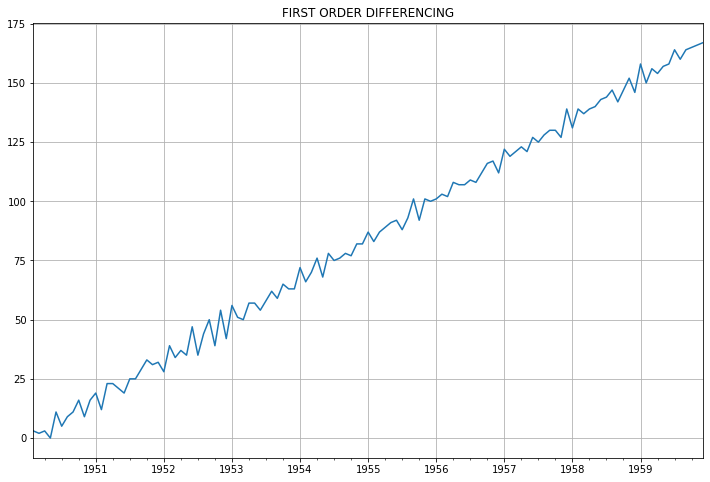

In [15]:
# First we will look at the first order difference of dataset 'c'
df['1c'] = df['c'].diff()

df['1c'].plot(figsize=(12, 8), title='FIRST ORDER DIFFERENCING', grid=True).autoscale(axis='x', tight=True)

Now let's apply a second order difference to dataset "c".

In [16]:
# We can do this from the original timeseries in one step
df['2c'] = df['c'].diff().diff()

df[['c', '1c', '2c']].head()

,c,1c,2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.0,NaN
1950-03-01,5,2.0,-1.0
1950-04-01,8,3.0,1.0
1950-05-01,8,0.0,-3.0


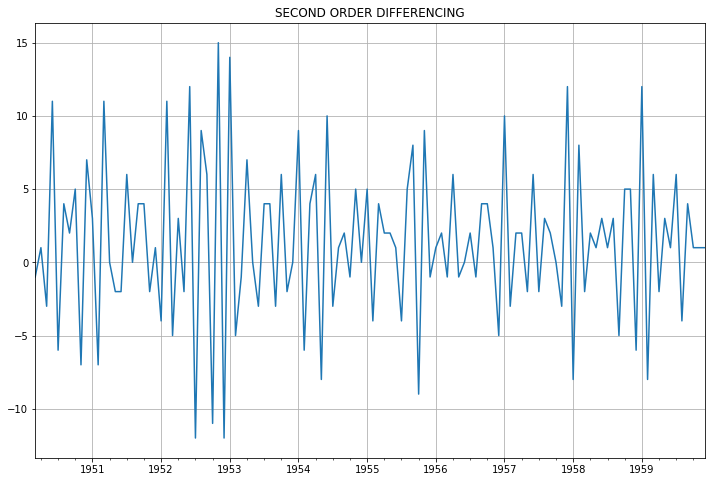

In [17]:
# Plot the second order differenced values
df['2c'].plot(figsize=(12, 8), title='SECOND ORDER DIFFERENCING', grid=True).autoscale(axis='x', tight=True)

Now the series has become stationary

<div class="alert alert-info"><strong>NOTE: </strong>This is different from <font color=black><tt>df2['c'].diff(2)</tt></font>, which would provide a first order difference spaced 2 lags apart.<br>
We'll use this technique later to address seasonality.</div>

### Forecasting on second order differenced data
As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to <tt>df['d2c']</tt> are <tt>[7,-2,5,-1,12]</tt>.

In [18]:
# For our example we need to build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


One way to invert a 2nd order transformation is to follow the formula above:

In [20]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df['c'].iloc[-2:]

# Apply the formula
for i in z['Fcast']:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

z['forecast']=forecast
z

,Fcast,forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


Another, perhaps more straightforward method is to create a first difference set from the second, then build the forecast set from the first difference. We'll again use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [21]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df['c'].iloc[-1] - df['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


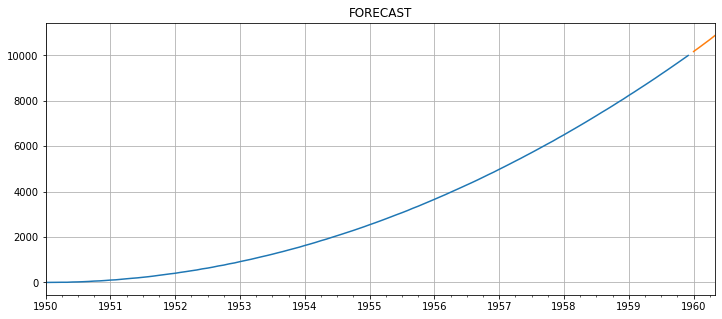

In [23]:
df['c'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot(grid=True)

<div class="alert alert-danger"><strong>NOTE:</strong> statsmodels has a built-in differencing tool:<br>
    
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;from statsmodels.tsa.statespace.tools import diff<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;df2['d1'] = diff(df2['b'],k_diff=1)</font></tt><br><br>
    
that performs the same first order differencing operation shown above. We chose not to use it here because seasonal differencing is somewhat complicated. To difference based on 12 lags, the code would be<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = diff(df2['b'],k_diff=0,k_seasonal_diff=1,seasonal_periods=12)
</font></tt><br><br>

whereas with pandas it's simply<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = df2['b'].diff(12)
</font></tt>
</div>

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>

# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.